<a href="https://colab.research.google.com/github/myllanes/Introduction-to-Deep-Learning/blob/main/HW4_2_Attention_English_To_French.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Michael Yllanes
# Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 16.0 MB/s eta 0:00:00
Epoch 0, Training Loss: 4.2160, Validation Loss: 3.0481
Epoch 10, Training Loss: 3.0760, Validation Loss: 3.8587
Epoch 20, Training Loss: 2.9281, Validation Loss: 4.1037
Epoch 30, Training Loss: 2.3897, Validation Loss: 4.5608
Epoch 40, Training Loss: 1.7282, Validation Loss: 5.1334
Epoch 50, Training Loss: 0.8639, Validation Loss: 5.8523
Epoch 60, Training Loss: 0.2027, Validation Loss: 6.6348
Epoch 70, Training Loss: 0.0732, Validation Loss: 7.0272
Epoch 80, Training Loss: 0.0431, Validation Loss: 7.1471
Epoch 90, Training Loss: 0.0307, Validation Loss: 7.2532
Epoch 100, Training Loss: 0.0237, Validation Loss: 7.4657
Epoch 110, Training Loss: 0.0193, Validation Loss: 7.5691
Epoch 120, Training Loss: 0.0162, Validation Loss: 7.5371
Epoch 130, Training Loss: 0.0140, Validation Loss: 7.5855
Epoch 140, Training Loss: 0.0123, Validation Loss: 7.7617
Epoch 150, Training Loss: 0.0109, Validation Loss: 7.8178
Ep

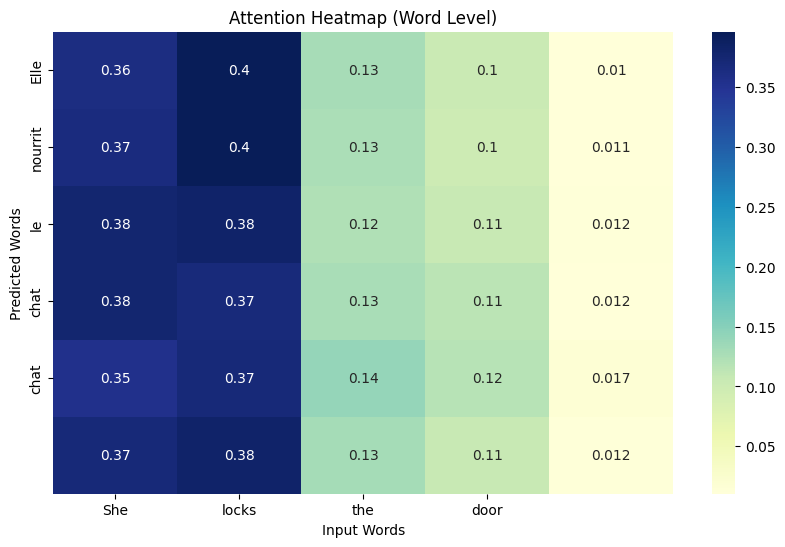

Input: She speaks French fluently
Target: Elle parle français couramment
Predicted: Elle parle français couramment couramment


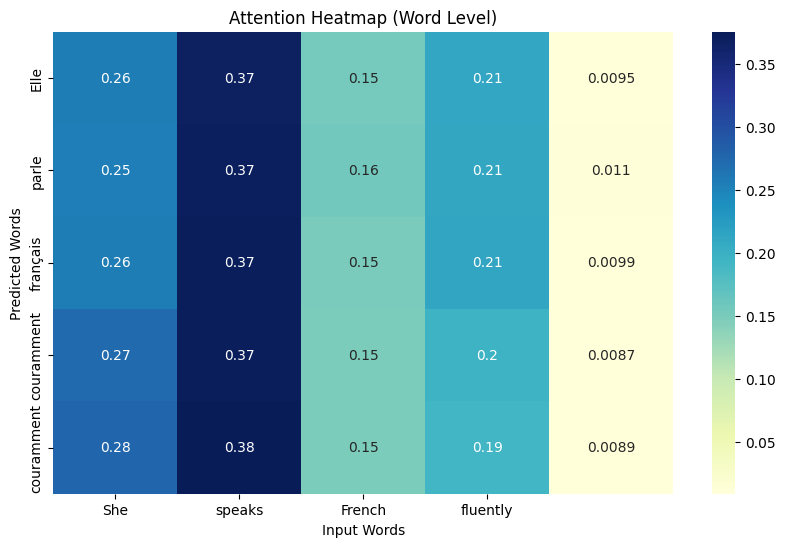

Input: He sings in the choir
Target: Il chante dans le chœur
Predicted: Il chante dans le chœur


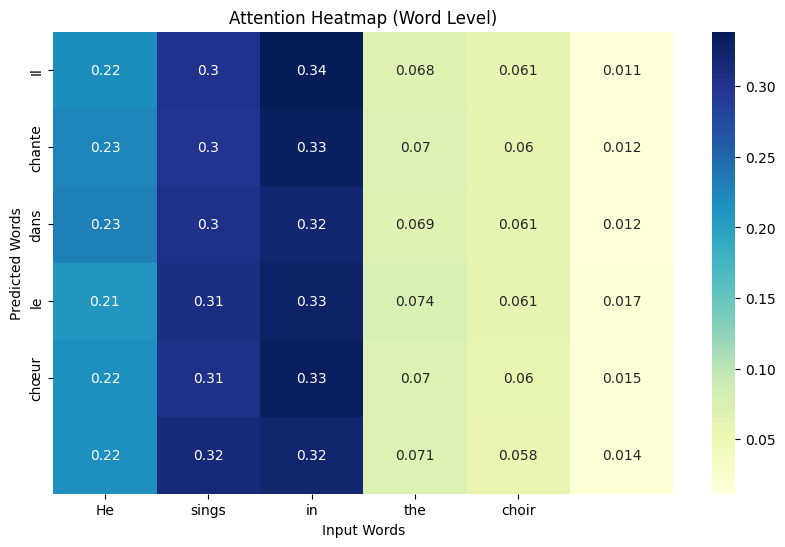

Input: We learn something new every day
Target: Nous apprenons quelque chose de nouveau chaque jour
Predicted: Nous apprenons quelque chose de nouveau chaque jour


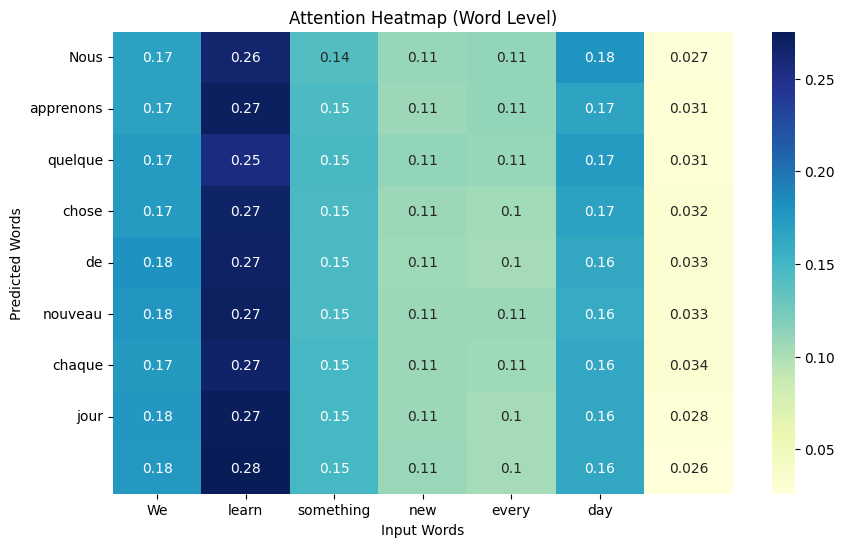

Input: They hike in the forest
Target: Ils font de la randonnée dans la forêt
Predicted: Ils nagent dans le musée


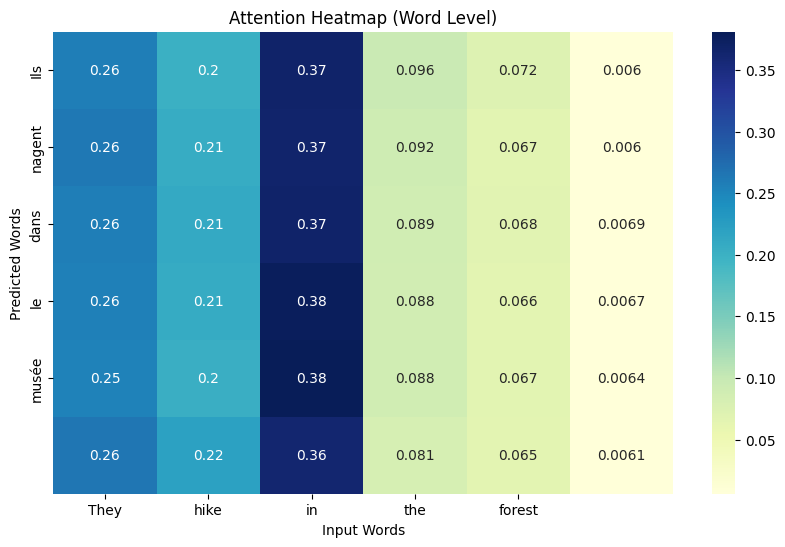

Evaluation Loss: 2.1989982118301294, Accuracy: 0.4336283185840708


In [4]:
!pip install python-docx

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import random
import ast
from sklearn.model_selection import train_test_split
from docx import Document
import matplotlib.pyplot as plt
import seaborn as sns

# Path to the .docx file in Google Drive
file_path = '/content/drive/My Drive/Dataset_English_to_French.docx'

doc = Document(file_path)

text = []
for paragraph in doc.paragraphs:
    text.append(paragraph.text)

text = '\n'.join(text)

start_index = text.find('[')
end_index = text.rfind(']') + 1
list_content = text[start_index:end_index]

dataset = ast.literal_eval(list_content)

# Tokenize into words
SOS_token = 0
EOS_token = 1

all_words = set()
for pair in dataset:
    all_words.update(pair[0].split() + pair[1].split())

word_to_index = {"SOS": SOS_token, "EOS": EOS_token, **{word: i+2 for i, word in enumerate(sorted(list(all_words)))}}
index_to_word = {i: word for word, i in word_to_index.items()}

class TranslationDataset(Dataset):
    def __init__(self, dataset, word_to_index):
        self.dataset = dataset
        self.word_to_index = word_to_index

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        input_sentence, target_sentence = self.dataset[idx]
        input_tensor = torch.tensor([self.word_to_index[word] for word in input_sentence.split()] + [EOS_token], dtype=torch.long)
        target_tensor = torch.tensor([self.word_to_index[word] for word in target_sentence.split()] + [EOS_token], dtype=torch.long)
        return input_tensor, target_tensor

translation_dataset = TranslationDataset(dataset, word_to_index)
dataloader = DataLoader(translation_dataset, batch_size=1, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset, val_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

train_translation_dataset = TranslationDataset(train_dataset, word_to_index)
val_translation_dataset = TranslationDataset(val_dataset, word_to_index)

train_dataloader = DataLoader(train_translation_dataset, batch_size=1, shuffle=True)
val_dataloader = DataLoader(val_translation_dataset, batch_size=1, shuffle=False)

class Encoder(nn.Module):
    def __init__(self, input_size, en_out, hidden_size):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, en_out)
        self.lstm = nn.LSTM(en_out, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output, hidden = self.lstm(embedded, hidden)
        return output, hidden

    def initHidden(self):
        return (torch.zeros(1, 1, self.hidden_size, device=device),
                torch.zeros(1, 1, self.hidden_size, device=device))

class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_size * 2, hidden_size)
        self.v = nn.Parameter(torch.rand(hidden_size))

    def forward(self, hidden, encoder_outputs):
        seq_len = encoder_outputs.size(0)
        batch_size = encoder_outputs.size(1)
        hidden_size = encoder_outputs.size(2)

        hidden_repeated = hidden[0].repeat(seq_len, 1, 1)
        energy = torch.tanh(self.attn(torch.cat((hidden_repeated, encoder_outputs), 2)))
        energy = energy.transpose(0, 1)
        v = self.v.repeat(batch_size, 1).unsqueeze(1)
        attention_weights = torch.bmm(v, energy.transpose(1, 2)).squeeze(1)
        return torch.nn.functional.softmax(attention_weights, dim=1)

class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size * 2, hidden_size)
        self.attention = Attention(hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        attn_weights = self.attention(hidden[0], encoder_outputs)
        attn_applied = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs.transpose(0, 1))
        attn_applied = attn_applied.transpose(0, 1)
        lstm_input = torch.cat((embedded, attn_applied), 2)
        output, hidden = self.lstm(lstm_input, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden, attn_weights

input_size = len(word_to_index)
hidden_size = 256
output_size = len(word_to_index)

encoder = Encoder(input_size=input_size, en_out=64, hidden_size=hidden_size).to(device)
decoder = Decoder(hidden_size=hidden_size, output_size=output_size).to(device)

encoder_optimizer = optim.SGD(encoder.parameters(), lr=0.01)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=0.01)
criterion = nn.NLLLoss()

# Training function
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=12):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    loss = 0

    # Encoding step: Pass through the encoder
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei].unsqueeze(0), encoder_hidden)

    # Initialize decoder input (SOS_token) and hidden state
    decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS token
    decoder_hidden = encoder_hidden

    # Decoding step: Loop through the target sequence
    for di in range(target_length):
        decoder_output, decoder_hidden, _ = decoder(decoder_input, decoder_hidden, encoder_output)
        topv, topi = decoder_output.topk(1)  # Get top prediction
        decoder_input = topi.squeeze().detach()  # Next input to decoder is the predicted token

        # Calculate loss
        loss += criterion(decoder_output, target_tensor[di].unsqueeze(0))

        # Stop if EOS token is predicted
        if decoder_input.item() == EOS_token:
            break

    # Backpropagation
    loss.backward()

    # Update encoder and decoder parameters
    encoder_optimizer.step()
    decoder_optimizer.step()

    # Return average loss
    return loss.item() / target_length


# Training loop
n_epochs = 200
for epoch in range(n_epochs):
    # Training phase
    encoder.train()
    decoder.train()
    total_train_loss = 0
    for input_tensor, target_tensor in train_dataloader:
        input_tensor = input_tensor[0].to(device)
        target_tensor = target_tensor[0].to(device)
        loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        total_train_loss += loss
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Validation phase
    encoder.eval()
    decoder.eval()
    total_val_loss = 0
    correct_predictions = 0
    with torch.no_grad():
        for input_tensor, target_tensor in val_dataloader:
            input_tensor = input_tensor[0].to(device)
            target_tensor = target_tensor[0].to(device)
            encoder_hidden = encoder.initHidden()
            input_length = input_tensor.size(0)
            target_length = target_tensor.size(0)
            loss = 0

            # Encoding step
            for ei in range(input_length):
                encoder_output, encoder_hidden = encoder(input_tensor[ei].unsqueeze(0), encoder_hidden)

            # Decoding step
            decoder_input = torch.tensor([[SOS_token]], device=device)
            decoder_hidden = encoder_hidden

            predicted_indices = []

            # Decoding step
            for di in range(target_length):
                decoder_output, decoder_hidden, _ = decoder(decoder_input, decoder_hidden, encoder_output)
                topv, topi = decoder_output.topk(1)  # Get top prediction
                decoder_input = topi.squeeze().detach()  # Next input to decoder is the predicted token

                # Calculate loss
                loss += criterion(decoder_output, target_tensor[di].unsqueeze(0))

                # Stop if EOS token is predicted
                if decoder_input.item() == EOS_token:
                    break

            # Calculate validation loss
            total_val_loss += loss.item() / target_length

            # Calculate accuracy
            target_indices = target_tensor.tolist()
            if predicted_indices == target_indices:
                correct_predictions += 1

    avg_val_loss = total_val_loss / len(val_dataloader)
    val_accuracy = correct_predictions / len(val_dataloader)

    # Print training and validation
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')



# Evaluation function
def evaluate_and_show_examples(encoder, decoder, dataloader, criterion, n_examples=5):
    encoder.eval()
    decoder.eval()

    total_loss = 0
    correct_predictions = 0

    with torch.no_grad():
        for i, (input_tensor, target_tensor) in enumerate(dataloader):
            input_tensor = input_tensor[0].to(device)
            target_tensor = target_tensor[0].to(device)

            encoder_hidden = encoder.initHidden()

            input_length = input_tensor.size(0)
            target_length = target_tensor.size(0)

            loss = 0

            # Encoding step
            encoder_outputs = torch.zeros(input_length, 1, encoder.hidden_size, device=device)
            for ei in range(input_length):
                encoder_output, encoder_hidden = encoder(input_tensor[ei].unsqueeze(0), encoder_hidden)
                encoder_outputs[ei] = encoder_output[0, 0]

            # Decoding step
            decoder_input = torch.tensor([[SOS_token]], device=device)
            decoder_hidden = encoder_hidden

            predicted_indices = []
            attention_weights_list = []

            for di in range(target_length):
                decoder_output, decoder_hidden, attn_weights = decoder(decoder_input, decoder_hidden, encoder_outputs)
                topv, topi = decoder_output.topk(1)
                predicted_indices.append(topi.item())
                decoder_input = topi.squeeze().detach()

                loss += criterion(decoder_output, target_tensor[di].unsqueeze(0))
                attention_weights_list.append(attn_weights.squeeze().cpu().numpy())

                if decoder_input.item() == EOS_token:
                    break

            # Calculate and print loss and accuracy
            total_loss += loss.item() / target_length
            if predicted_indices == target_tensor.tolist():
                correct_predictions += 1

            # Pprint some examples
            if i < n_examples:
                input_words = [index_to_word[index.item()] for index in input_tensor if index.item() not in (SOS_token, EOS_token)]
                target_words = [index_to_word[index.item()] for index in target_tensor if index.item() not in (SOS_token, EOS_token)]
                predicted_words = [index_to_word[index] for index in predicted_indices if index not in (SOS_token, EOS_token)]

                print(f'Input: {" ".join(input_words)}')
                print(f'Target: {" ".join(target_words)}')
                print(f'Predicted: {" ".join(predicted_words)}')

                # Create attention heatmap
                attention_matrix = np.array(attention_weights_list)
                plt.figure(figsize=(10, 6))
                sns.heatmap(attention_matrix, annot=True, cmap="YlGnBu",
                            xticklabels=input_words, yticklabels=predicted_words)
                plt.xlabel("Input Words")
                plt.ylabel("Predicted Words")
                plt.title("Attention Heatmap (Word Level)")
                plt.show()

        # Print overall evaluation results
        average_loss = total_loss / len(dataloader)
        accuracy = correct_predictions / len(dataloader)
        print(f'Evaluation Loss: {average_loss}, Accuracy: {accuracy}')

# Perform evaluation
evaluate_and_show_examples(encoder, decoder, dataloader, criterion)

# New Section